In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from langdetect import detect

In [2]:
%%time
raw_df = pd.read_csv("Data/business_wire_scrape_results.csv", index_col=0)

Wall time: 779 ms


In [3]:
df = raw_df.copy()
df["time"] = pd.to_datetime(df.time)

In [4]:
a = df.groupby("time").time.count()

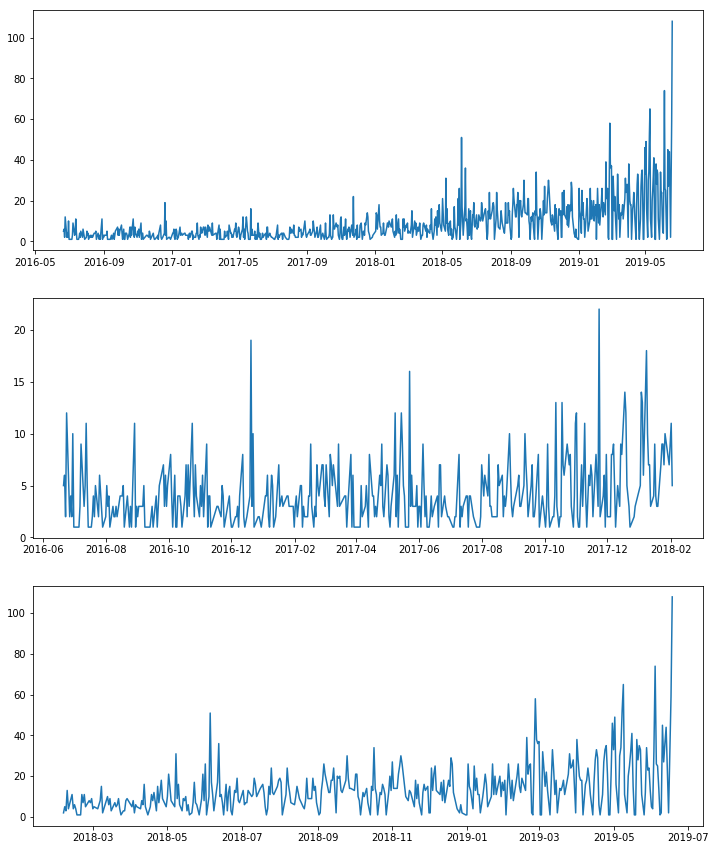

In [8]:
fig, ax = plt.subplots(3, figsize=(12, 15))
ax[0].plot(a.iloc[-800:])
ax[1].plot(a.iloc[-800:-400])
ax[2].plot(a.iloc[-400:])

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8806 entries, 0 to 49
Data columns (total 5 columns):
link       8806 non-null object
time       8806 non-null datetime64[ns]
title      8806 non-null object
ticker     8806 non-null object
article    8802 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 412.8+ KB


So it appears that there are 4 items that do not have an article. Will remove these.

In [4]:
df = df.dropna()

## Sample

Let's take a look at a few sample data points:

In [32]:
for ind, row in df.sample(5).iterrows():
    for col in row.index:
        print(row[col], "\n")
    print("\n\n")

http://www.businesswire.com/news/home/20171030006297/en/SHAREHOLDER-ALERT-Levi-Korsinsky-LLP-Notifies-Shareholders 

2017-10-30 00:00:00 

SHAREHOLDER ALERT: Levi & Korsinsky, LLP Notifies Shareholders of Intercept Pharmaceuticals, Inc. of a Class Action Lawsuit and a Lead Plaintiff Deadline of November 27, 2017 

ICPT 

 NEW YORK--(BUSINESS WIRE)--The following statement is being issued by Levi & Korsinsky, LLP: To: All persons or entities who purchased or otherwise acquired securities of Intercept Pharmaceuticals, Inc. ("Intercept") (NASDAQ:ICPT) between May 31, 2016 and September 20, 2017. You are hereby notified that a securities class action lawsuit has been commenced in the United States District Court for the Southern District of New York. To get more information go to: http://www.zlk.com/plsra-c/intercept-pharmaceuticals-inc?wire=3 or contact Joseph E. Levi, Esq. either via email at jlevi@levikorsinsky.com or by telephone at (212) 363-7500, toll-free: (877) 363-5972. There is n

### Notes
* First off, the last article is in French! I will have to find a way to determine the language of an article and either remove the French articles or translate them to English (hard problem)
* At the beginning of each article is {location} -- (BUSINESS WIRE) -- {article}
    * this could actually give an extra piece of metadata regarding the article: location of print
    * Further this can be seperated with a function splitting the data by " -- "
* There are also websites in some of the articles. For now, I will not be collecting data off of secondary sources and the website will not work well in later steps. They should be removed.

## First Run Data Cleaning

### Language Detection

Using langdetect's function "detect" will determine the major language of each article.

Instead of taking an entire article and trying to detect the language for it, it would be better to take a subsample as this would make the function quite a bit faster.

In [5]:
def detect_subsample(article):
    sub_article = article[50:250]
    return detect(sub_article)

In [6]:
%%time
df["article_language"] = df.article.apply(detect_subsample)

Wall time: 44.8 s


In [7]:
df.article_language.unique()

array(['en', 'fr', 'de', 'es', 'it', 'pt', 'nl', 'vi', 'pl', 'cs', 'ja',
       'zh-cn', 'ko', 'zh-tw', 'lv'], dtype=object)

#### Seperate the Data into English and Non-English

In [8]:
non_english_df = df.loc[df.article_language != "en"]
df = df.loc[df.article_language == "en"]

In [19]:
for ind, sample in non_english_df.sample(5).iterrows():
    print(sample.article[:300], "\n")

 BASILEA, Svizzera e CAMBRIDGE, Massachusetts--(BUSINESS WIRE)--CRISPR Therapeutics, una società biofarmaceutica impegnata nell’ottenere dalla tecnologia di modifica del genoma CRISPR/Cas9 farmaci innovativi, oggi ha annunciato di avere raccolto altri 38 milioni di dollari alla chiusura del suo fina 

 GOSSELIES, België--(BUSINESS WIRE)--Regulatory News: “We hebben de voorbije zes maanden significante vooruitgang geboekt over de gehele pijplijn, met belangrijke veiligheids- en doeltreffendheidsresultaten van de lopende Fase II programma’s in vertraagd-helende breuken, vertebrale fusie en osteopor 

 TEANECK, NUEVA JERSEY--(BUSINESS WIRE)--Durante la Exposición Internacional de Producción y Procesamiento (IPPE) 2019, Phibro Animal Health presentará Provia™ Prime, su nuevo producto para la alimentación directa con microbianos que ayuda a optimizar el microbioma intestinal y promueve un mejor est 

 BASEL (Schweiz) und ILLKIRCH GRAFFENSTADEN (Frankreich)--(BUSINESS WIRE)--CRISPR Therapeut

Great, it seems that we have seperated the lagnuage types.

### Split The Article by Format

In [9]:
def split_article(article):
    # format: location -- (BUSINESS WIRE) -- article
    # For now, only take the article
    try:
        split_article = article.split("--")
        return split_article[2]
    except Exception as e:
        print(str(e))
        return None

In [28]:
# Use this to drop article so I do not have to start the pipeline from the beginning
df.drop("article", axis=1, inplace=True)

In [10]:
# Rename the article column to original_article
df.columns = ['link', 'time', 'title', 'ticker', 'original_article', 'article_language']

# apply the function above using apply
df["article"] = df.original_article.apply(split_article)

df.head()

,link,time,title,ticker,original_article,article_language,article
0,http://www.businesswire.com/news/home/20190604...,2019-06-04,ACADIA Pharmaceuticals to Present at the Goldm...,ACAD,SAN DIEGO--(BUSINESS WIRE)--ACADIA Pharmaceut...,en,"ACADIA Pharmaceuticals Inc. (Nasdaq: ACAD), a ..."
1,http://www.businesswire.com/news/home/20190518...,2019-05-18,ACADIA Pharmaceuticals to Present Phase 2 CLAR...,ACAD,SAN DIEGO--(BUSINESS WIRE)--ACADIA Pharmaceut...,en,"ACADIA Pharmaceuticals Inc. (Nasdaq: ACAD), a ..."
2,http://www.businesswire.com/news/home/20190515...,2019-05-15,Fastest Growing Companies/Startups in San Fran...,ACAD,"BOULDER, Colo.--(BUSINESS WIRE)--Growjo annou...",en,Growjo announced the fastest growing companies...
3,http://www.businesswire.com/news/home/20190507...,2019-05-07,ACADIA Pharmaceuticals to Present at the Bank ...,ACAD,SAN DIEGO--(BUSINESS WIRE)--ACADIA Pharmaceut...,en,"ACADIA Pharmaceuticals Inc. (Nasdaq: ACAD), a ..."
4,http://www.businesswire.com/news/home/20190502...,2019-05-02,"Alzheimer's Disease: Pipeline Review, Develope...",ACAD,"DUBLIN--(BUSINESS WIRE)--The ""Alzheimer's Dis...",en,"The ""Alzheimer's Disease: Pipeline Review, Dev..."


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8436 entries, 0 to 49
Data columns (total 7 columns):
link                8436 non-null object
time                8436 non-null datetime64[ns]
title               8436 non-null object
ticker              8436 non-null object
original_article    8436 non-null object
article_language    8436 non-null object
article             8436 non-null object
dtypes: datetime64[ns](1), object(6)
memory usage: 527.2+ KB


### Remove URL from Article Text

In [11]:
def remove_urls (vTEXT):
    # https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
    try:
        vTEXT = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', vTEXT, flags=re.MULTILINE)
        return(vTEXT)
    except Exception as e:
        print(str(e))
        print(type(vTEXT))
        return None

In [33]:
sample_text_with_url = df.iloc[4].article
print("BEFORE:")
print(sample_text_with_url)
print("\nAFTER")
print(remove_urls(sample_text_with_url))

BEFORE:
The "Alzheimer's Disease: Pipeline Review, Developer Landscape and Competitive Insights" report has been added to ResearchAndMarkets.com's offering. “Alzheimer's Disease: Pipeline Review, Developer Landscape and Competitive Insights”Tweet this Alzheimer's disease is a neurodegenerative condition characterized by progressive memory loss, cognitive dysfunction and dementia. Currently, it is the most commonly reported neurodegenerative disorder across the world, and the sixth leading cause of death in the US. It was estimated that, in 2018, nearly 5.7 million Americans (considering all age groups) were living with Alzheimer's disease. During the same year, Alzheimer's disease and other dementias were projected to be responsible for a healthcare burden amounting to USD 277 billion, in the US. Considering that only a limited range of diagnosis, treatment and disease management solutions are presently available, this segment of the healthcare industry is presently faced with a pressi

In [12]:
%%time
df["article"] = df.article.apply(remove_urls)

Wall time: 2.48 s


### Remove Unnecessary Columns

In [13]:
df.drop(["link", "article_language", "original_article"], axis=1, inplace=True)

In [14]:
# re-order the columns
df = df[["time", "ticker", "title", "article"]]
df.head()

,time,ticker,title,article
0,2019-06-04,ACAD,ACADIA Pharmaceuticals to Present at the Goldm...,"ACADIA Pharmaceuticals Inc. (Nasdaq: ACAD), a ..."
1,2019-05-18,ACAD,ACADIA Pharmaceuticals to Present Phase 2 CLAR...,"ACADIA Pharmaceuticals Inc. (Nasdaq: ACAD), a ..."
2,2019-05-15,ACAD,Fastest Growing Companies/Startups in San Fran...,Growjo announced the fastest growing companies...
3,2019-05-07,ACAD,ACADIA Pharmaceuticals to Present at the Bank ...,"ACADIA Pharmaceuticals Inc. (Nasdaq: ACAD), a ..."
4,2019-05-02,ACAD,"Alzheimer's Disease: Pipeline Review, Develope...","The ""Alzheimer's Disease: Pipeline Review, Dev..."


In [15]:
# Create a clean copy of the df for later use
clean_df = df.copy()

# NLP

I will be following along with this blog post about text summarization as well as branching off and exploring the NLTK modules.

https://towardsdatascience.com/write-a-simple-summarizer-in-python-e9ca6138a08e

In [16]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.probability import FreqDist
from heapq import nlargest
from collections import defaultdict

### Data Cleanup

Will use a sample article's text to test the methods on:

In [17]:
sample = df.iloc[0].article

In [18]:
sample[:300]

'ACADIA Pharmaceuticals Inc. (Nasdaq: ACAD), a biopharmaceutical company focused on the development and commercialization of innovative medicines that address unmet medical needs in central nervous system disorders, today announced that it will present at the Goldman Sachs 40th Annual Global Healthca'

In [102]:
def sanitize_input(data):
    '''Removes all white spaces that are not a single space between words.'''
    replace = {
        ord('\f') : ' ',
        ord('\t') : ' ',
        ord('\n') : ' ',
        ord('\r') : None,
    }

    data = data.translate(replace) # Note I have never seen .translate for strings. This is an interesting function**
    return re.sub('[0-9]+', '', data)

In [20]:
sample = sanitize_input(sample)

In [21]:
def tokenize_content(content):
    # Removes stop words as well as punctuation then gives a list of words
    stop_words = set(stopwords.words('english') + list(punctuation))
    words = word_tokenize(content.lower())
    
    return [
        sent_tokenize(content),
        [word for word in words if word not in stop_words]    
    ]

In [22]:
tokenized_sentence, tokenized_word = tokenize_content(sample)

In [23]:
def score_tokens(filterd_words, sentence_tokens):
    # Score by frequency of a word
    # The value of ranking will then contain key values of the sentence’s numeric position, and their score.
    word_freq = FreqDist(filterd_words)

    ranking = defaultdict(int)

    for i, sentence in enumerate(sentence_tokens):
        for word in word_tokenize(sentence.lower()):
            if word in word_freq:
                ranking[i] += word_freq[word]
                
    return ranking

In [24]:
rankings = score_tokens(tokenized_word, tokenized_sentence)
rankings

defaultdict(int, {0: 68, 1: 35, 2: 49, 3: 23, 4: 35, 5: 13})

In [25]:
def summarize(ranks, sentences, length):
    """
    Utilizes a ranking map produced by score_token to extract
    the highest ranking sentences in order after converting from
    array to string.  
    """
    if int(length) > len(sentences): 
        print("Error, more sentences requested than available. Use --l (--length) flag to adjust.")
        exit()

    indexes = nlargest(length, ranks, key=ranks.get)
    final_sentences = [sentences[j] for j in sorted(indexes)]
    return ' '.join(final_sentences)

In [26]:
summary = summarize(rankings, tokenized_sentence, 2)
summary

'ACADIA Pharmaceuticals Inc. (Nasdaq: ACAD), a biopharmaceutical company focused on the development and commercialization of innovative medicines that address unmet medical needs in central nervous system disorders, today announced that it will present at the Goldman Sachs 40th Annual Global Healthcare Conference on Tuesday, June 11, 2019 at 1:20 p.m. Pacific Time in Rancho Palos Verdes, California. About ACADIA Pharmaceuticals ACADIA is a biopharmaceutical company focused on the development and commercialization of innovative medicines to address unmet medical needs in central nervous system disorders.'

That is it for the author's summarizer. Now we can start exploring the NLTK modules.

##### Word Frequency

FreqDist(words) gives the frequency of each word. This could be important to determine which words are used most. 

Intuitively would be good to remove a few words that will have a high frequency such as the company's name, pharmaceutical, company, etc. It may be good to conglomerate all of the articles together and begin processing all of the text data. Could possible vectorize and simply apply a clustering algorithm.

In [27]:
word_freq = FreqDist(tokenized_word)
word_freq

FreqDist({'acadia': 7, 'company': 3, 'development': 3, 'unmet': 3, '’': 3, 'pharmaceuticals': 2, 'biopharmaceutical': 2, 'focused': 2, 'commercialization': 2, 'innovative': 2, ...})

## NLP Data Exploration

Will collect all of the articles together into one large body of writing. Then apply word frequency and take a look at the results.

In [98]:
sample_df = df.sample(200)
mass_article = ""
for art in sample_df.article.values:
    mass_article = mass_article + art

In [103]:
def apply_word_freq(article):
    sanitized = sanitize_input(article)
    _, tokenized_words = tokenize_content(sanitized)
    return FreqDist(tokenized_words)

In [104]:
%%time
word_freq = pd.Series(apply_word_freq(mass_article), name="word_freq")
word_freq.sort_values(inplace=True, ascending=False)
word_freq = word_freq.to_frame()

Wall time: 2.3 s


In [105]:
word_freq.head(10)

,word_freq
market,976
company,755
million,728
development,651
sales,546
inc.,518
statements,493
therapeutics,459
clinical,438
products,428


Ok, so clearly some punction did not get parsed out. Let's take a look at the words of length 1, which should include all of those punctuations that were missed.

*edit* changed this to words of less than or equal to 3 as I doubt any of those words have importance.

In [106]:
word_freq["word_length"] = pd.Series(word_freq.index, index = word_freq.index).apply(len)

word_freq.head(10)

,word_freq,word_length
market,976,6
company,755,7
million,728,7
development,651,11
sales,546,5
inc.,518,4
statements,493,10
therapeutics,459,12
clinical,438,8
products,428,8


In [107]:
single_chars = word_freq.loc[word_freq.word_length <= 3]
single_chars.head()

,word_freq,word_length
net,420,3
may,375,3
new,364,3
€,344,1
..,267,2


In [108]:
single_chars = single_chars.index.tolist()
print(single_chars)

['net', 'may', 'new', '€', '..', 'key', '-.', 'us', 'de', 'per', 'use', 'inc', 'one', 'due', 'end', 'two', 'la', 'bio', 'law', 'eur', 'en', 'et', 'sec', 'ag', 'st', 'pnh', 'omt', 'act', 'set', 'see', 'evt', 'ffo', 'al', 'los', 'led', 'co', 'el', 'th', 'iot', 'top', '--', 'cut', 'trc', 'ckd', 'lab', 'que', 'car', '-k', 'sa', 'low', 'iv', 'roa', '+.', 'zai', 'mm', 'nda', 'red', 'dng', '-q', 'age', 'rna', 'eli', 'via', 'eu', 'raw', 'las', 'idc', 'pd', 'mk', 'ec', 'con', 'cic', 'day', 'eha', 'fad', 'se', 'gi', 'ci', 'pm', 'ab', 'arm', 'way', 'nd', 'id', 'sg', 'ph', 'ny', 'iba', 'más', 'mcg', 'del', 'web', 'fdc', 'ca', 'ai', 'e.g', 'nv', '«', 'row', 'met', '»', 'acs', 'os', 'lp', 'pet', 'un', 'aim', 'par', 'md-', 'jun', 'hr=', 'ias', 'med', 'gmg', 'una', 'get', 'rac', 'btc', 'nhi', 'ha', 'gp', 'es', 'sus', 'bg', 'ce', 's-', 'ash', 'pcr', 'por', 'pay', 'mi', 'aid', 'w', 'qw', 'xb', 'ibd', '.–.', 'iw-', 'ccr', '.–', 'x', 'ema', 'ent', 'tom', 'jet', 'b/', 'cap', 'pro', 'ani', 'sm', 'htt', 'mit

Ok, so by the looks of it, these can all be removed from the data as well. So, will update the tokenize function above.

In [109]:
def tokenize_content(content):
    # Removes stop words as well as punctuation then gives a list of words
    stop_words = set(stopwords.words('english') + list(punctuation) + single_chars)
    words = word_tokenize(content.lower())
    
    return [
        sent_tokenize(content),
        [word for word in words if word not in stop_words]    
    ]

def apply_word_freq(article):
    sanitized = sanitize_input(article)
    _, tokenized_words = tokenize_content(sanitized)
    return FreqDist(tokenized_words)

In [110]:
%%time
word_freq = pd.Series(apply_word_freq(mass_article), name="word_freq")
word_freq.sort_values(inplace=True, ascending=False)
word_freq = word_freq.to_frame()

word_freq["word_length"] = pd.Series(word_freq.index, index = word_freq.index).apply(len)

print(word_freq.head(20))

              word_freq  word_length
market              976            6
’                   838            1
”                   790            1
“                   784            1
company             755            7
million             728            7
development         651           11
sales               546            5
inc.                518            4
statements          493           10
therapeutics        459           12
clinical            438            8
products            428            8
report              424            6
global              389            6
group               389            5
first               388            5
income              387            6
drug                385            4
information         380           11
Wall time: 2.42 s


Now, the tough part here is going to be that many of the words will be common to almost all news articles. We really only want to keep words that would give "useful" demarcation to the data. For example:

* "inc." is not a very valuable word
* "therapeutics" is a very general word since almost everything will be about therapeutics.

In [111]:
word_freq.shape

(12043, 2)

Further, there are over 12,000 words to parse through. Which is a lot.

Is it possible to find how many articles each word is in? That might illicit some demarcation details.

In [112]:
%%time
def num_articles_is_in(word):
    tally = 0
    # note that this is global at this point, which is not good soft. engineering. Will need to fix in production.
    for article in sample_df.article.values:
        if word in article:
            tally += 1
    return tally

word_freq["num_articles"] = pd.Series(word_freq.index, index=word_freq.index).apply(num_articles_is_in)

Wall time: 15 s


In [113]:
word_freq.head(20)

,word_freq,word_length,num_articles
market,976,6,130
’,838,1,102
”,790,1,164
“,784,1,163
company,755,7,110
million,728,7,47
development,651,11,125
sales,546,5,37
inc.,518,4,1
statements,493,10,62


Notice that there are words such as keytruda that have 487 instances over 2 articles. This makes no sense. Let's first take out any word that is in less than 10% of the articles (this can be undone later). Then can find an average article frequency.

In [114]:
filtered_freq_df = word_freq.loc[word_freq.num_articles > 30] # Note 300 is the number of articles from earlier, should be
                                                              # replaced for something dynamic later.
filtered_freq_df["avg_article_freq"] = filtered_freq_df.word_freq / filtered_freq_df.num_articles

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [115]:
top_100_words = list(filtered_freq_df.sort_values("avg_article_freq", ascending=False).iloc[:100].index)

In [116]:
print(top_100_words)

['million', 'sales', '’', 'statements', 'operating', 'market', 'financial', 'company', 'therapeutics', 'first', 'forward-looking', 'patients', 'operations', 'development', 'cancer', 'results', '”', '“', 'global', 'products', 'quarter', 'research', 'clinical', 'pipeline', 'companies', 'study', 'performance', 'share', 'trials', 'capital', 'treatment', 'activities', 'revenue', 'therapy', 'data', 'growth', 'second', 'drug', 'regulatory', 'medical', 'general', 'shares', 'healthcare', 'analysis', 'common', 'business', 'including', 'risks', 'report', 'increase', 'period', 'discovery', 'future', 'management', 'prior', 'industry', 'candidates', 'associated', 'disease', 'related', 'ended', 'impact', 'diseases', 'markets', 'health', 'investors', 'platform', 'technologies', 'three', 'drugs', 'following', 'safety', 'trial', 'year', 'therapies', 'available', 'product', 'manufacturing', 'could', 'forecast', 'years', 'expected', 'system', 'partners', "'s", 'additional', 'previous', 'application', 'fac

## Word Reduction

The goal is to remove words that are not going to be relevant to classifying the subject of the news report.

For example:

* Numbers
* Dates
* Non descriptive words (Nouns, Adjectives, Verbs, etc.)

Further, will want to remove words with a very low frequency.

In [117]:
# Recall we still have this data set
filtered_freq_df.head()

,word_freq,word_length,num_articles,avg_article_freq
market,976,6,130,7.507692
’,838,1,102,8.215686
”,790,1,164,4.817073
“,784,1,163,4.809816
company,755,7,110,6.863636


For numbers, dates, and other types of punctuation can go through each word, if there are any non alphabetic characters then the word should be removed.

In [118]:
word_series = pd.Series(filtered_freq_df.index, index=filtered_freq_df.index)

In [119]:
def contains_non_letter(word):
    for i in word:
        if i not in "abcdefghijklmnopqrstuvwxyz":
            return True
    return False

word_freq["letter_only"] = word_series.apply(contains_non_letter)

In [120]:
word_freq = word_freq.loc[word_freq.letter_only == False].drop("letter_only", axis=1)
word_freq.head()

,word_freq,word_length,num_articles
market,976,6,130
company,755,7,110
million,728,7,47
development,651,11,125
sales,546,5,37


In [122]:
word_freq.shape

(571, 3)

Nice! Down to only 571 words. That seems like a great amount of reduction!

### Word Embedding and Clustering

Note that there is going to be some more filtering I would like to do prior to this step, but I am going to keep this here since I was searching for it.

https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

In [123]:
sentences = sent_tokenize(mass_article)
word_list = list(word_freq.index)
sentences = [[word for word in word_tokenize(sent.lower()) if word in word_list] for sent in sentences]

In [125]:
elligable_sentences = []
for item in sentences:
    if len(item) > 0:
        elligable_sentences.append(item)

In [127]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

In [128]:
w2v_model = Word2Vec(elligable_sentences, min_count=5)
X = w2v_model[w2v_model.wv.vocab]

pca_model = PCA(n_components=2)

x_transformed = pca_model.fit_transform(X)

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


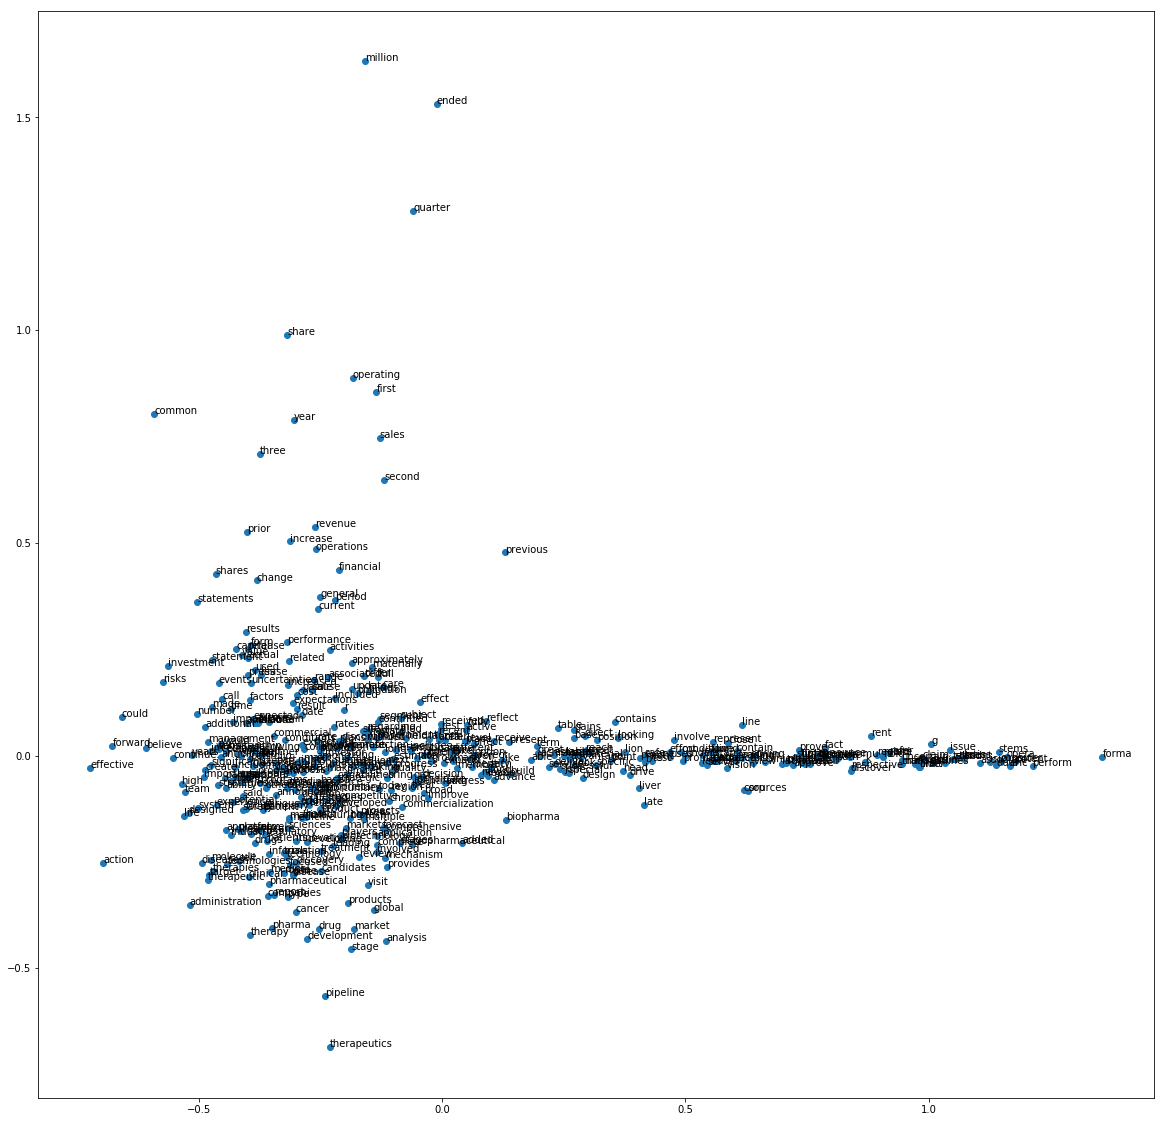

In [129]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(x_transformed[:, 0], x_transformed[:, 1])
words = list(w2v_model.wv.vocab)

for i, word in enumerate(words):
    ax.annotate(word, xy=(x_transformed[i, 0], x_transformed[i, 1]))

In [170]:
# Most similar to a word
w2v_model.most_similar('clinical')

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('trials', 0.9985016584396362),
 ('candidates', 0.9977760314941406),
 ('trial', 0.9967674612998962),
 ('regulatory', 0.9954501986503601),
 ('approval', 0.994572639465332),
 ('patients', 0.9944903254508972),
 ('studies', 0.9943149089813232),
 ('treatment', 0.9941661953926086),
 ('safety', 0.9935094118118286),
 ('gene', 0.9933806657791138)]

In [171]:
# Get the actual word vector
w2v_model['clinical']

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.1193357 , -0.28357345,  0.06119477, -0.07404085,  0.20594913,
        0.03916118, -0.22215861,  0.35150686,  0.12325027, -0.17598888,
       -0.17828001, -0.08646152, -0.28449467,  0.03979645,  0.18421212,
        0.16785364, -0.00643646,  0.45417845, -0.23092143,  0.3179245 ,
        0.11197387, -0.02611075, -0.21677081,  0.20017324, -0.4860019 ,
        0.09176117,  0.02610812,  0.10682307, -0.1428309 ,  0.509541  ,
        0.22248088,  0.18644367,  0.1155354 ,  0.27398226, -0.08525775,
        0.13594237,  0.09637522,  0.30364946, -0.0753953 ,  0.03290268,
       -0.11323036, -0.10319306, -0.18014547, -0.18356949, -0.28269187,
        0.13203712, -0.36696628,  0.01218406,  0.19642533, -0.10347184,
        0.25512648, -0.11699622,  0.10008428, -0.1815017 ,  0.09685731,
        0.05953504,  0.26980653, -0.06963655, -0.02356678, -0.09332541,
        0.1001453 ,  0.05635553,  0.00652386,  0.13140702,  0.06168203,
        0.05423858,  0.00931775,  0.27831393, -0.00721245, -0.31

For fun, try to adjust the hierarchical clustering algorithm to be used on this vector space using a regular norm.

In [213]:
import sys
sys.path.append("../UtilityFunctions")
from HierarchicalClustering import *
import seaborn as sns

In [209]:
def hierarchical_cluster_2(distance_matrix):
    distances = get_edge_lengths(distance_matrix)

    set_clusters = initialize_set_clusters(list(distance_matrix.columns))

    weights = {i: 1 for i in distance_matrix.columns}

    cluster, optimal_weights = get_hierarchical_weights(set_clusters, distances, weights)

    clustered_index = cluster.get_end_child()

    return distance_matrix[clustered_index].loc[clustered_index]

In [187]:
#words_in_model = w2v_model
words_in_model = list(w2v_model.wv.vocab.keys())

In [192]:
dist_matrix = []
for item1 in words_in_model:
    col = []
    for item2 in words_in_model:
        v1 = w2v_model[item1]
        v2 = w2v_model[item2]
        col.append(np.linalg.norm(v1-v2))
    dist_matrix.append(col)

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [193]:
dist_df = pd.DataFrame(dist_matrix, 
                       columns=words_in_model, 
                       index=words_in_model)

In [195]:
hc = hierarchical_cluster_2(dist_df)

In [217]:
fig, ax = plt.subplots(figsize=(200, 200))
sns.heatmap(hc, ax=ax)